In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib widget

import importlib
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import ExperimentClass
import tools
import math_functions as mf

In [2]:
importlib.reload(ExperimentClass)
fluo_liquide = ExperimentClass.Experiment("20230427_cross_validation_fluo_liq", "Fluo_Liquide")
fluo_liquide.Time = fluo_liquide.Time - fluo_liquide.Time[0]
All_Acquisitions_df = fluo_liquide.annotations.copy()

fig_folder = fluo_liquide.path + "/Figures"
if not os.path.isdir(fig_folder):
    os.mkdir(fig_folder)



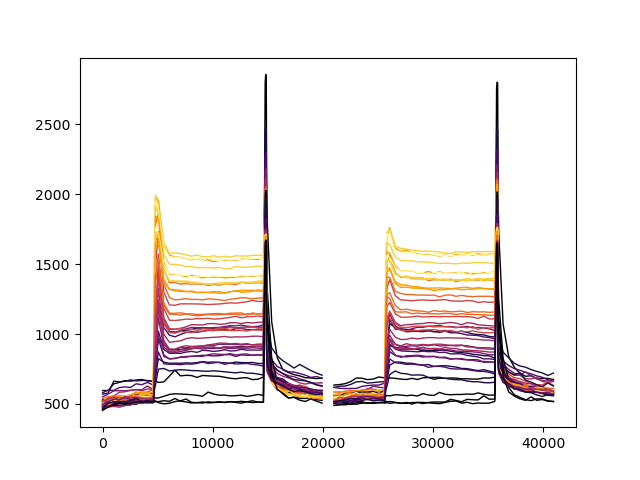

In [3]:
# visualize some acquisitions

import matplotlib.cm as cm

fig, ax = plt.subplots()
act = sorted(list(set(All_Acquisitions_df.Actinic)))
cmap = plt.cm.get_cmap('inferno', len(act))

for k, i in enumerate(fluo_liquide.Data.keys()):
    actinic = All_Acquisitions_df.Actinic[All_Acquisitions_df.Record == float(i.replace('E', ''))]
    if k % 2 == 0:
        ax.plot(fluo_liquide.Time , fluo_liquide.Data[i], linewidth = 1, color = cmap(act.index(actinic.values[0])), label = actinic)
    else:
        ax.plot(fluo_liquide.Time + 21000 , fluo_liquide.Data[i], linewidth = 1, color = cmap(act.index(actinic.values[0])), label = actinic)


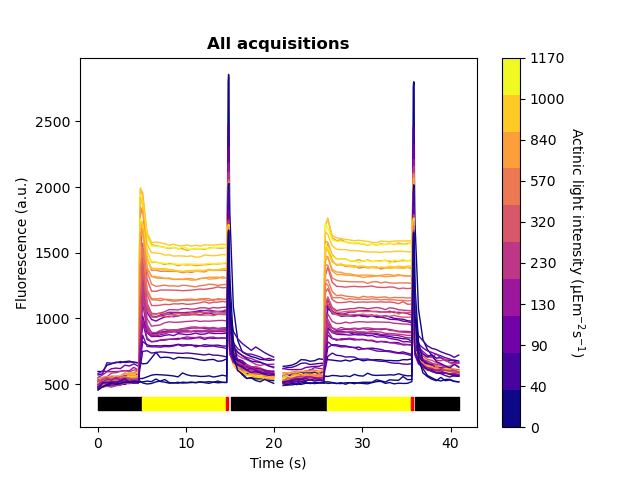

In [4]:
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.cm import ScalarMappable

fig, ax = plt.subplots()
act = sorted(list(set(All_Acquisitions_df.Actinic)))
cmap = plt.cm.get_cmap('plasma', len(act))

for k, i in enumerate(fluo_liquide.Data.keys()):
    actinic = All_Acquisitions_df.Actinic[All_Acquisitions_df.Record == float(i.replace('E', ''))]
    if k % 2 == 0:
        ax.plot(fluo_liquide.Time/1000 , fluo_liquide.Data[i],  linewidth = 1, color = cmap(act.index(actinic.values[0])), label = actinic)
    else:
        ax.plot(fluo_liquide.Time/1000 + 21 , fluo_liquide.Data[i], linewidth = 1, color = cmap(act.index(actinic.values[0])), label = actinic)

# add cmap legend
sm = ScalarMappable(norm=colors.Normalize(vmin=0, vmax=len(act)-1), cmap=cmap)
sm.set_array([])
cbar = plt.colorbar(sm, ticks=range(len(act)))
cbar.ax.set_yticklabels(act)
cbar.ax.set_ylabel('Actinic light intensity (µEm$^{-2}$s$^{-1}$)', rotation=270, labelpad=15)

ax.set_xlabel('Time (s)')
ax.set_ylabel('Fluorescence (a.u.)')
ax.set_title('All acquisitions', fontweight = 'bold')

time = np.linspace(0, max(fluo_liquide.Time/1000 + 21), 1000)
ax.fill_between(time, 300, 400, color='black', where=np.logical_or.reduce((time < 5, np.logical_and(time > 15, time < 26), time > 36)))
ax.fill_between(time, 300, 400, color='yellow', where= ~np.logical_or.reduce((time < 5, np.logical_and(time > 14.5, time < 26), time > 35.5)))
ax.fill_between(time, 300, 400, color='red', where= np.logical_or.reduce((np.logical_and(time > 14.5, time < 14.8), np.logical_and(time > 35.5, time < 35.8) )))

fig.savefig(fig_folder + "/all_acq_raw.png", dpi = 300)


In [101]:
def compute_params(Data_df, Acquisitions_df):
    
    F_max = []
    F_stat = []
    F_0 = []
    phi_stat = []
    phi_0 = []
    NPQ = []
    ETR = []

    for i, k in enumerate(Acquisitions_df.Record):
        F_max.append(np.mean(Data_df[f"E{k}"][33:36]))
        F_max[i] = F_max[i]
        F_0.append(np.mean(Data_df[f"E{k}"][2:11]))
        F_stat.append(np.mean(Data_df[f"E{k}"][25:33]))
        phi_stat.append((F_max[i] - F_stat[i]) / F_max[i])
        phi_0.append((F_max[i] - F_0[i]) / F_max[i])
        NPQ.append((F_max[0] - F_max[i])/F_max[i])
        ETR.append(phi_stat[i] * float(Acquisitions_df.Actinic[Acquisitions_df.Record == k]))
        
    norm = F_max[0]
    
    F_max = list(np.array(F_max)/norm)
    F_stat = list(np.array(F_stat)/norm)
    F_0 = list(np.array(F_0)/norm)
        
    params_df = pd.DataFrame({'Real_time': Acquisitions_df.Real_time, 'Record': Acquisitions_df.Record, 'Actinic': Acquisitions_df.Actinic, 'F_max': F_max, 'F_stat': F_stat, 'F_0': F_0, 'phi_stat': phi_stat, 'phi_0': phi_0, 'NPQ': NPQ, 'ETR': ETR})
    
    return params_df
    
def actinic_light_axes(ax, Acquisitions_df, params_df):
    ax[0].plot(Acquisitions_df.Actinic, params_df.F_max, '-', linewidth = 0.5, label = 'F_max')
    ax[0].plot(Acquisitions_df.Actinic, params_df.F_0, '-', linewidth = 0.5, label = 'F_0')
    ax[0].plot(Acquisitions_df.Actinic, params_df.F_stat, '-', linewidth = 0.5, label = 'F_stat')
    ax[0].legend()  

    ax[1].plot(Acquisitions_df.Actinic, params_df.phi_stat, '-', linewidth = 0.5, label = 'phi_stat')
    ax[1].plot(Acquisitions_df.Actinic, params_df.phi_0, '-', linewidth = 0.5, label = 'phi_0')
    ax[1].legend()

    ax[2].plot(Acquisitions_df.Actinic, params_df.NPQ, '-', linewidth = 0.5, label = 'NPQ')
    ax[2].legend()
    
    return ax
        

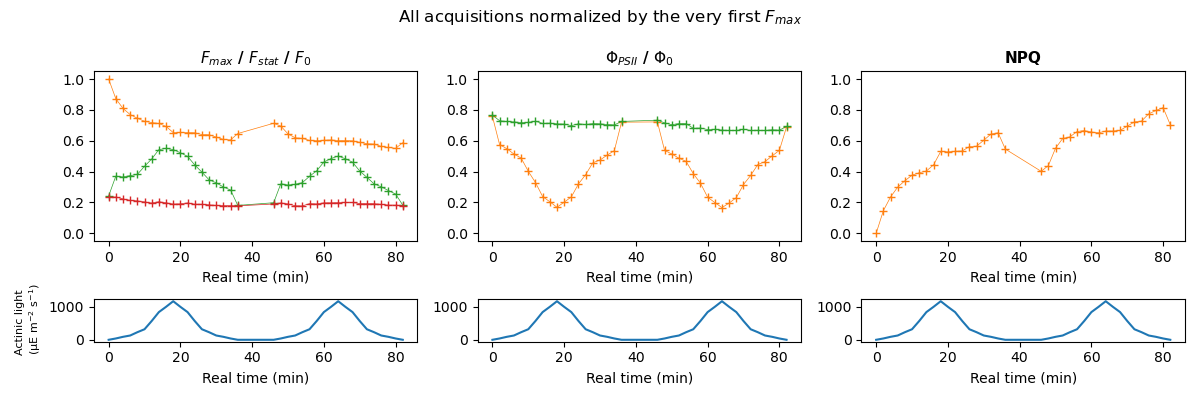

In [102]:
params_df = []
params_df.append(compute_params(fluo_liquide.Data, All_Acquisitions_df[(All_Acquisitions_df['Acquisition'] == 1)]))

fig, ax = plt.subplots(2,3, figsize = (12,4), gridspec_kw={'height_ratios': [4, 1]})
fig.suptitle("All acquisitions normalized by the very first $F_{max}$")

ax[0,0].plot(params_df[0].Real_time, params_df[0].F_max, '+-', linewidth = 0.5, color = 'C1', label = '$F_{max}$')
ax[0,0].plot(params_df[0].Real_time, params_df[0].F_stat, '+-', linewidth = 0.5, color = 'C2', label = '$F_{stat}$')
ax[0,0].plot(params_df[0].Real_time, params_df[0].F_0, '+-', linewidth = 0.5, color = 'C3', label = '$F_{0}$')

ax[0,0].set_title('$F_{max}$ / $F_{stat}$ / $F_{0}$', fontsize = 11, fontweight = 'bold')


ax[0,1].plot(params_df[0].Real_time, params_df[0].phi_stat, '+-', linewidth = 0.5, label = '$Φ_{PSII}$', color = 'C1')
ax[0,1].plot(params_df[0].Real_time, params_df[0].phi_0, '+-', linewidth = 0.5, label = '$Φ_{0}$', color = 'C2')

ax[0,1].set_title('$Φ_{PSII}$ / $Φ_{0}$', fontsize = 11, fontweight = 'bold')


ax[0,2].plot(params_df[0].Real_time, params_df[0].NPQ, '+-', linewidth = 0.5, label = 'NPQ', color = 'C1')

ax[0,2].set_title('NPQ', fontsize = 11, fontweight = 'bold')


for i in [0, 1, 2]:
    ax[1,i].plot(params_df[0].Real_time, params_df[0].Actinic)
    
ax[1,0].set_ylabel("Actinic light \n (µE m$^{-2}$ s$^{-1}$)", fontsize = 8)
    

ax = ax.flatten()

[ax.set_xlabel("Real time (min)", fontsize = 10) for ax in ax]
#[ax.legend(fontsize = 8.5) for ax in ax[:3]]
[ax.set_ylim(-0.05,1.05) for ax in ax[:3]]

ax = ax.reshape(2,3)

fig.tight_layout()

fig.savefig(fig_folder + "/all_acq_time_1norm.png", dpi = 300)



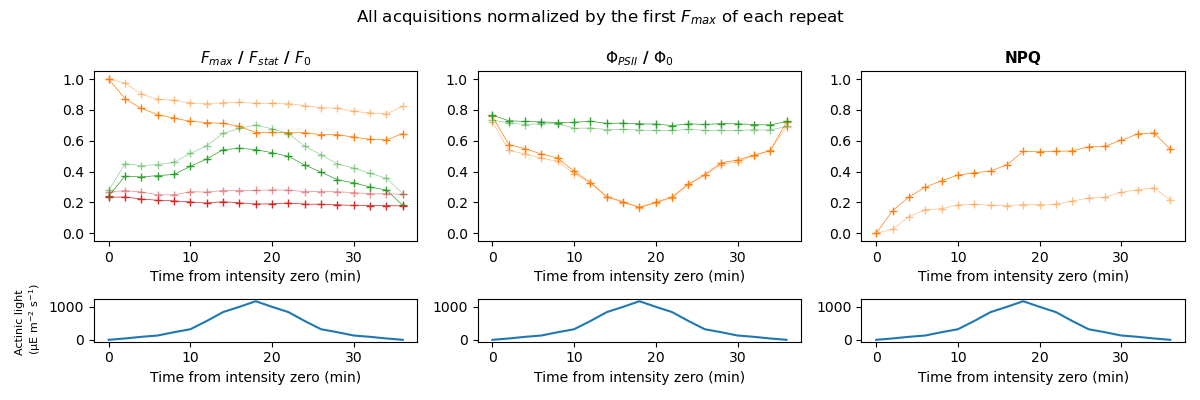

In [103]:
params_df = []
params_df.append(compute_params(fluo_liquide.Data, All_Acquisitions_df[(All_Acquisitions_df['Repeat'] == 1) & (All_Acquisitions_df['Acquisition'] == 1)]))
params_df.append(compute_params(fluo_liquide.Data, All_Acquisitions_df[(All_Acquisitions_df['Repeat'] == 2) & (All_Acquisitions_df['Acquisition'] == 1)]))

fig, ax = plt.subplots(2,3, figsize = (12,4), gridspec_kw={'height_ratios': [4, 1]})
fig.suptitle("All acquisitions normalized by the first $F_{max}$ of each repeat")

ax[0,0].plot(params_df[0].Real_time, params_df[0].F_max, '+-', linewidth = 0.5, color = 'C1', label = '$F_{max}$')
ax[0,0].plot(params_df[0].Real_time, params_df[0].F_stat, '+-', linewidth = 0.5, color = 'C2', label = '$F_{stat}$')
ax[0,0].plot(params_df[0].Real_time, params_df[0].F_0, '+-', linewidth = 0.5, color = 'C3', label = '$F_{0}$')

ax[0,0].plot(params_df[0].Real_time, params_df[1].F_max, '+-', linewidth = 0.5, color = 'C1', label = '$F_{max}$', alpha = 0.5)
ax[0,0].plot(params_df[0].Real_time, params_df[1].F_stat, '+-', linewidth = 0.5, color = 'C2', label = '$F_{stat}$', alpha = 0.5)
ax[0,0].plot(params_df[0].Real_time, params_df[1].F_0, '+-', linewidth = 0.5, color = 'C3', label = '$F_{0}$', alpha = 0.5)

ax[0,0].set_title('$F_{max}$ / $F_{stat}$ / $F_{0}$', fontsize = 11, fontweight = 'bold')


ax[0,1].plot(params_df[0].Real_time, params_df[0].phi_stat, '+-', linewidth = 0.5, label = '$Φ_{PSII}$', color = 'C1')
ax[0,1].plot(params_df[0].Real_time, params_df[0].phi_0, '+-', linewidth = 0.5, label = '$Φ_{0}$', color = 'C2')

ax[0,1].plot(params_df[0].Real_time, params_df[1].phi_stat, '+-', linewidth = 0.5, label = '$Φ_{PSII}$', color = 'C1', alpha = 0.5)
ax[0,1].plot(params_df[0].Real_time, params_df[1].phi_0, '+-', linewidth = 0.5, label = '$Φ_{0}$', color = 'C2', alpha = 0.5)

ax[0,1].set_title('$Φ_{PSII}$ / $Φ_{0}$', fontsize = 11, fontweight = 'bold')


ax[0,2].plot(params_df[0].Real_time, params_df[0].NPQ, '+-', linewidth = 0.5, label = 'NPQ', color = 'C1')

ax[0,2].plot(params_df[0].Real_time, params_df[1].NPQ, '+-', linewidth = 0.5, label = 'NPQ', color = 'C1', alpha = 0.5)

ax[0,2].set_title('NPQ', fontsize = 11, fontweight = 'bold')


for i in [0, 1, 2]:
    ax[1,i].plot(params_df[0].Real_time, params_df[0].Actinic)
    
ax[1,0].set_ylabel("Actinic light \n (µE m$^{-2}$ s$^{-1}$)", fontsize = 8)
    

ax = ax.flatten()

[ax.set_xlabel("Time from intensity zero (min)", fontsize = 10) for ax in ax]
#[ax.legend(fontsize = 8.5) for ax in ax[:3]]
[ax.set_ylim(-0.05,1.05) for ax in ax[:3]]

ax = ax.reshape(2,3)

fig.tight_layout()

fig.savefig(fig_folder + "/all_acq_time_2norm.png", dpi = 300)



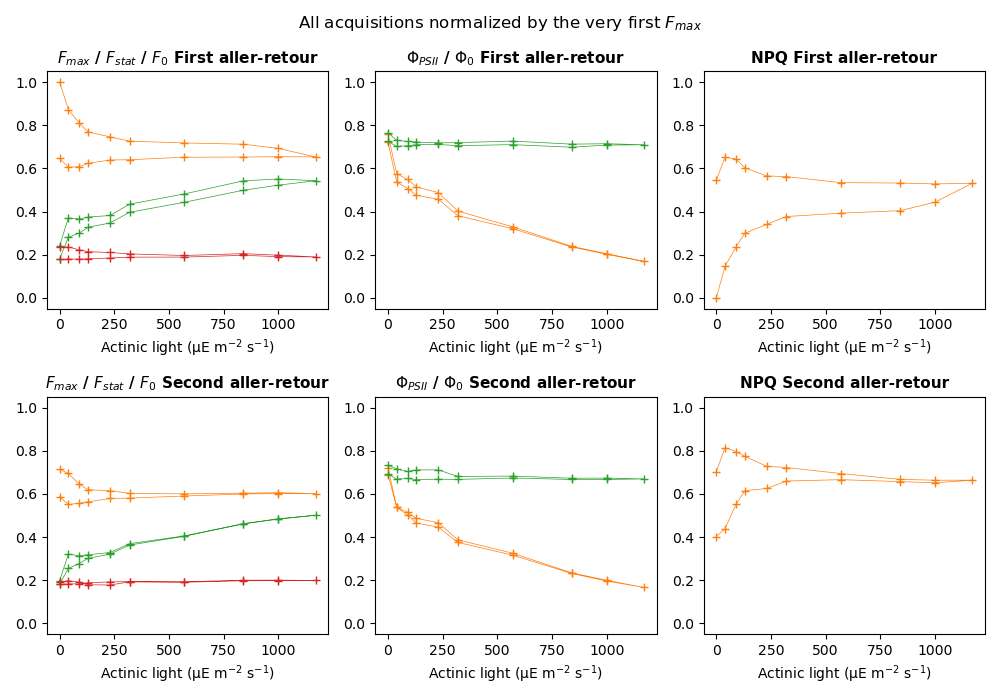

In [112]:
params_df = []
params_df.append(compute_params(fluo_liquide.Data, All_Acquisitions_df[(All_Acquisitions_df['Acquisition'] == 1)]))

fig, ax = plt.subplots(2,3, figsize = (10,7))
fig.suptitle("All acquisitions normalized by the very first $F_{max}$")

ax[0,0].plot(params_df[0].Actinic[:19], params_df[0].F_max[:19], '+-', linewidth = 0.5, color = 'C1', label = '$F_{max}$')
ax[0,0].plot(params_df[0].Actinic[:19], params_df[0].F_stat[:19], '+-', linewidth = 0.5, color = 'C2', label = '$F_{stat}$')
ax[0,0].plot(params_df[0].Actinic[:19], params_df[0].F_0[:19], '+-', linewidth = 0.5, color = 'C3', label = '$F_{0}$')

ax[1,0].plot(params_df[0].Actinic[19:], params_df[0].F_max[19:], '+-', linewidth = 0.5, color = 'C1', label = '$F_{max}$', alpha = 1)
ax[1,0].plot(params_df[0].Actinic[19:], params_df[0].F_stat[19:], '+-', linewidth = 0.5, color = 'C2', label = '$F_{stat}$', alpha = 1)
ax[1,0].plot(params_df[0].Actinic[19:], params_df[0].F_0[19:], '+-', linewidth = 0.5, color = 'C3', label = '$F_{0}$', alpha = 1)

ax[0,0].set_title('$F_{max}$ / $F_{stat}$ / $F_{0}$ First aller-retour', fontsize = 11, fontweight = 'bold')
ax[1,0].set_title('$F_{max}$ / $F_{stat}$ / $F_{0}$ Second aller-retour', fontsize = 11, fontweight = 'bold')


ax[0,1].plot(params_df[0].Actinic[:19], params_df[0].phi_stat[:19], '+-', linewidth = 0.5, label = '$Φ_{PSII}$', color = 'C1')
ax[0,1].plot(params_df[0].Actinic[:19], params_df[0].phi_0[:19], '+-', linewidth = 0.5, label = '$Φ_{0}$', color = 'C2')

ax[1,1].plot(params_df[0].Actinic[19:], params_df[0].phi_stat[19:], '+-', linewidth = 0.5, label = '$Φ_{PSII}$', color = 'C1', alpha = 1)
ax[1,1].plot(params_df[0].Actinic[19:], params_df[0].phi_0[19:], '+-', linewidth = 0.5, label = '$Φ_{0}$', color = 'C2', alpha = 1)

ax[0,1].set_title('$Φ_{PSII}$ / $Φ_{0}$ First aller-retour', fontsize = 11, fontweight = 'bold')
ax[1,1].set_title('$Φ_{PSII}$ / $Φ_{0}$ Second aller-retour', fontsize = 11, fontweight = 'bold')


ax[0,2].plot(params_df[0].Actinic[:19], params_df[0].NPQ[:19], '+-', linewidth = 0.5, label = 'NPQ', color = 'C1')

ax[1,2].plot(params_df[0].Actinic[19:], params_df[0].NPQ[19:], '+-', linewidth = 0.5, label = 'NPQ', color = 'C1', alpha = 1)

ax[0,2].set_title('NPQ First aller-retour', fontsize = 11, fontweight = 'bold')
ax[1,2].set_title('NPQ Second aller-retour', fontsize = 11, fontweight = 'bold')

ax = ax.flatten()
    
[ax.set_xlabel("Actinic light (µE m$^{-2}$ s$^{-1}$)", fontsize = 10) for ax in ax]
[ax.set_ylim(-0.05,1.05) for ax in ax]

fig.tight_layout()

fig.savefig(fig_folder + "/histerese_1norm.png", dpi = 300)



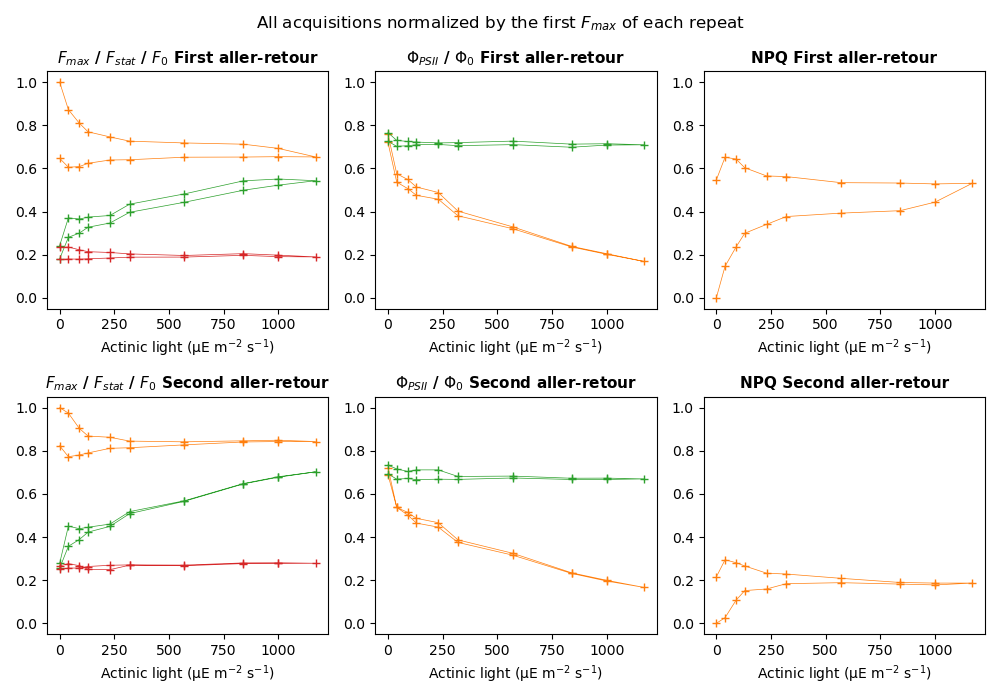

In [107]:
params_df = []
params_df.append(compute_params(fluo_liquide.Data, All_Acquisitions_df[(All_Acquisitions_df['Repeat'] == 1) & (All_Acquisitions_df['Acquisition'] == 1)]))
params_df.append(compute_params(fluo_liquide.Data, All_Acquisitions_df[(All_Acquisitions_df['Repeat'] == 2) & (All_Acquisitions_df['Acquisition'] == 1)]))

fig, ax = plt.subplots(2,3, figsize = (10,7))
fig.suptitle("All acquisitions normalized by the first $F_{max}$ of each repeat")

ax[0,0].plot(params_df[0].Actinic, params_df[0].F_max, '+-', linewidth = 0.5, color = 'C1', label = '$F_{max}$')
ax[0,0].plot(params_df[0].Actinic, params_df[0].F_stat, '+-', linewidth = 0.5, color = 'C2', label = '$F_{stat}$')
ax[0,0].plot(params_df[0].Actinic, params_df[0].F_0, '+-', linewidth = 0.5, color = 'C3', label = '$F_{0}$')

ax[1,0].plot(params_df[0].Actinic, params_df[1].F_max, '+-', linewidth = 0.5, color = 'C1', label = '$F_{max}$', alpha = 1)
ax[1,0].plot(params_df[0].Actinic, params_df[1].F_stat, '+-', linewidth = 0.5, color = 'C2', label = '$F_{stat}$', alpha = 1)
ax[1,0].plot(params_df[0].Actinic, params_df[1].F_0, '+-', linewidth = 0.5, color = 'C3', label = '$F_{0}$', alpha = 1)

ax[0,0].set_title('$F_{max}$ / $F_{stat}$ / $F_{0}$ First aller-retour', fontsize = 11, fontweight = 'bold')
ax[1,0].set_title('$F_{max}$ / $F_{stat}$ / $F_{0}$ Second aller-retour', fontsize = 11, fontweight = 'bold')


ax[0,1].plot(params_df[0].Actinic, params_df[0].phi_stat, '+-', linewidth = 0.5, label = '$Φ_{PSII}$', color = 'C1')
ax[0,1].plot(params_df[0].Actinic, params_df[0].phi_0, '+-', linewidth = 0.5, label = '$Φ_{0}$', color = 'C2')

ax[1,1].plot(params_df[0].Actinic, params_df[1].phi_stat, '+-', linewidth = 0.5, label = '$Φ_{PSII}$', color = 'C1', alpha = 1)
ax[1,1].plot(params_df[0].Actinic, params_df[1].phi_0, '+-', linewidth = 0.5, label = '$Φ_{0}$', color = 'C2', alpha = 1)

ax[0,1].set_title('$Φ_{PSII}$ / $Φ_{0}$ First aller-retour', fontsize = 11, fontweight = 'bold')
ax[1,1].set_title('$Φ_{PSII}$ / $Φ_{0}$ Second aller-retour', fontsize = 11, fontweight = 'bold')


ax[0,2].plot(params_df[0].Actinic, params_df[0].NPQ, '+-', linewidth = 0.5, label = 'NPQ', color = 'C1')

ax[1,2].plot(params_df[0].Actinic, params_df[1].NPQ, '+-', linewidth = 0.5, label = 'NPQ', color = 'C1', alpha = 1)

ax[0,2].set_title('NPQ First aller-retour', fontsize = 11, fontweight = 'bold')
ax[1,2].set_title('NPQ Second aller-retour', fontsize = 11, fontweight = 'bold')

ax = ax.flatten()
    
[ax.set_xlabel("Actinic light (µE m$^{-2}$ s$^{-1}$)", fontsize = 10) for ax in ax]
[ax.set_ylim(-0.05,1.05) for ax in ax]

fig.tight_layout()

fig.savefig(fig_folder + "/histerese_2norm.png", dpi = 300)



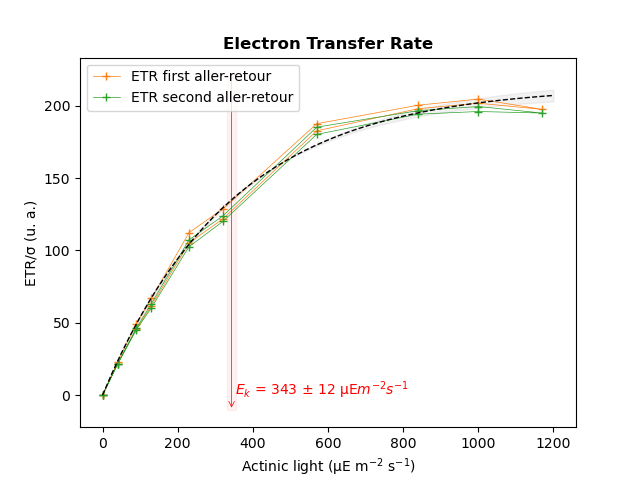

In [111]:
params_df = []
params_df.append(compute_params(fluo_liquide.Data, All_Acquisitions_df[(All_Acquisitions_df['Repeat'] == 1) & (All_Acquisitions_df['Acquisition'] == 1)]))
params_df.append(compute_params(fluo_liquide.Data, All_Acquisitions_df[(All_Acquisitions_df['Repeat'] == 2) & (All_Acquisitions_df['Acquisition'] == 1)]))
params_df.append(compute_params(fluo_liquide.Data, All_Acquisitions_df[(All_Acquisitions_df['Acquisition'] == 1)]))



fig, ax = plt.subplots()
ax.set_title("Electron Transfer Rate", fontweight = 'bold')
ax.plot(params_df[0].Actinic, params_df[0].ETR, '+-', linewidth = 0.5, label = 'ETR first aller-retour', color = 'C1')
ax.plot(params_df[0].Actinic, params_df[1].ETR, '+-', linewidth = 0.5, label = 'ETR second aller-retour', color = 'C2')

popt, pcov, xfit, yfit = tools.Ek_fit(params_df[2].Actinic, params_df[2].ETR, 0, 1200, 50, p0 = [200, 200])
err_neg=[mf.Ek(x,*(popt-1.96*tools.my_err_vec(x, pcov))) for x in xfit]
err_pos=[mf.Ek(x,*(popt+1.96*tools.my_err_vec(x, pcov)))for x in xfit]
ax.fill_between(xfit, err_neg, err_pos, alpha=0.05, color = 'k')
ax.plot(xfit, yfit, '--', color ='k', linewidth = 1)
Ek = popt[1]
Ek_err = np.sqrt(np.diag(pcov))[1]
ax.annotate("", xy=(Ek, ax.get_ylim()[0]), xytext=(Ek, ax.get_ylim()[1]), arrowprops=dict(arrowstyle="->", color="red", linewidth = 0.5))
ax.fill_betweenx(ax.get_ylim(), Ek - Ek_err, Ek + Ek_err, color='red', alpha=0.05)
ax.text(Ek + 10, 0.05, f"$E_k$ = {Ek:.0f} ± {Ek_err:.0f} µE$m^{{-2}} s^{{-1}}$", fontsize = 10, color = "red")

ax.legend()  
ax.set_xlabel("Actinic light (µE m$^{-2}$ s$^{-1}$)")
ax.set_ylabel("ETR/σ (u. a.)")

fig.savefig(fig_folder + "/ETR.png", dpi = 300)